In [3]:
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

fatal: destination path 'notebooks' already exists and is not an empty directory.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [4]:
from utils import *
setup_chapter()

No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Go to Runtime > Change runtime type and select a GPU hardware accelerator.
Using transformers v4.11.3
Using datasets v1.16.1


# Dataset

In [5]:
## IOB 2 data format
import pandas as pd

In [6]:
tokens = "Jeff Dean is a computer scientist at Google in California".split()

In [7]:
lbls = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "O", "B-LOC"]

In [8]:
df = pd.DataFrame([tokens,lbls], index = ['Tokens','Tags'])


In [9]:
df

,0,1,2,3,4,5,6,7,8,9
Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC


In [10]:
pd.DataFrame(list(zip(tokens,lbls)), columns = ['Tokens','Labels'])

,Tokens,Labels
0,Jeff,B-PER
1,Dean,I-PER
2,is,O
3,a,O
4,computer,O
5,scientist,O
6,at,O
7,Google,B-ORG
8,in,O
9,California,B-LOC


In [11]:
## Load Dataset, XTREME has multiple domains. First lets know about the PAN_X subsets within XTREME

In [12]:
from datasets import get_dataset_config_names

In [13]:
config_xtreme = get_dataset_config_names("xtreme")

In [14]:
len(config_xtreme)

183

In [15]:
panx_subsets = [s for s in config_xtreme if s.startswith("PAN")]

In [16]:
panx_subsets

['PAN-X.af',
 'PAN-X.ar',
 'PAN-X.bg',
 'PAN-X.bn',
 'PAN-X.de',
 'PAN-X.el',
 'PAN-X.en',
 'PAN-X.es',
 'PAN-X.et',
 'PAN-X.eu',
 'PAN-X.fa',
 'PAN-X.fi',
 'PAN-X.fr',
 'PAN-X.he',
 'PAN-X.hi',
 'PAN-X.hu',
 'PAN-X.id',
 'PAN-X.it',
 'PAN-X.ja',
 'PAN-X.jv',
 'PAN-X.ka',
 'PAN-X.kk',
 'PAN-X.ko',
 'PAN-X.ml',
 'PAN-X.mr',
 'PAN-X.ms',
 'PAN-X.my',
 'PAN-X.nl',
 'PAN-X.pt',
 'PAN-X.ru',
 'PAN-X.sw',
 'PAN-X.ta',
 'PAN-X.te',
 'PAN-X.th',
 'PAN-X.tl',
 'PAN-X.tr',
 'PAN-X.ur',
 'PAN-X.vi',
 'PAN-X.yo',
 'PAN-X.zh']

In [17]:
## The suffixes are language codes

In [18]:
## To load german, we need de as input

In [19]:
from datasets import load_dataset

In [20]:
load_dataset("xtreme", name = "PAN-X.de")

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
})

In [21]:
### Building dataset according to different languages

In [22]:
from collections import defaultdict
from datasets import DatasetDict

In [23]:
DatasetDict?

In [24]:
defaultdict?

In [25]:
# Returns a dataset dict if key doesn't exist

In [26]:
panx_ch = defaultdict(DatasetDict)

In [27]:
panx_ch

defaultdict(datasets.dataset_dict.DatasetDict, {})

In [28]:
langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]

In [29]:
for lang, frac in zip(langs, fracs):
  ds = load_dataset("xtreme", name = f"PAN-X.{lang}")

  ## Shuffle and downsample each split according to spoken proportion
  for split in ds:
    panx_ch[lang][split]  = (ds[split].shuffle(seed=0).select(range(int(frac*ds[split].num_rows))))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
panx_ch

defaultdict(datasets.dataset_dict.DatasetDict,
            {'de': DatasetDict({
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 12580
                 })
             }),
             'fr': DatasetDict({
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 2290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 2290
                 })
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'la

In [31]:
## Inspecting element
element = panx_ch["de"]["train"][0]

In [32]:
print(element)

{'tokens': ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in',
'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.'], 'ner_tags': [0, 0, 0, 0,
5, 6, 0, 0, 5, 5, 6, 0], 'langs': ['de', 'de', 'de', 'de', 'de', 'de', 'de',
'de', 'de', 'de', 'de', 'de']}


In [33]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER',
'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], names_file=None, id=None),
length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [34]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature

In [35]:
print(tags)

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG',
'B-LOC', 'I-LOC'], names_file=None, id=None)


In [36]:
### class label to names
tags.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [37]:
def create_tag_names(batch):
  return {"ner_tags_str":[tags.int2str(idx) for idx in batch["ner_tags"]]}

In [38]:
panx_de = panx_ch["de"].map(create_tag_names)

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/12580 [00:00<?, ?ex/s]

In [39]:
print(panx_de["train"][10])

{'tokens': ['Als', 'Bestandteil', 'des', 'Chianti', 'ist', 'die', 'Sorte',
'vor', 'allem', 'in', 'der', 'Toskana', 'verbreitet', '.'], 'ner_tags': [0, 0,
0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0], 'langs': ['de', 'de', 'de', 'de', 'de',
'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de'], 'ner_tags_str': ['O',
'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O']}


In [40]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
['Tokens', 'Tags'])
     

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


#### Distribution of each entity

In [41]:
from collections import Counter

In [42]:
Counter?

In [43]:
split2freqs = defaultdict(Counter)

In [44]:
split2freqs

defaultdict(collections.Counter, {})

In [45]:
panx_de.items()

dict_items([('validation', Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
    num_rows: 6290
})), ('test', Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
    num_rows: 6290
})), ('train', Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
    num_rows: 12580
}))])

In [46]:
split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
          

In [47]:
pd.DataFrame.from_dict(split2freqs, orient="index")
     

,ORG,LOC,PER
validation,2683,3172,2893
test,2573,3180,3071
train,5366,6186,5810


# Multi lingual transformers

Simmilar to monolingual transformers with the difference being these are trained on multiple languages at once. A remarkable thing is that despite receiving no specific instruction, the model can generalize accross all languages. This is called as Cross Linual Transfer.

Can be trained in 3 ways:
1. en: Fine Tune on English and then evaluate on each language's test set.

2. each: fine tune and evaluate on monolingual data to measure per language performance

3. all: fine tune on all the training data to evaluate on each language test set.

# Tokenizers

xlmr uses SentencePiece Tokenizer instead of Word Piece that is used by BERT

In [48]:
from transformers import AutoTokenizer

In [49]:
bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [50]:
text = "Jack Sparrow loves New Delhi"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [51]:
bert_tokens

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'Delhi', '[SEP]']

In [52]:
xlmr_tokens

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁Delhi', '</s>']

In [53]:
pd.DataFrame(zip(bert_tokens, xlmr_tokens), columns = ['bert','xlmr_roberta'])

,bert,xlmr_roberta
0,[CLS],<s>
1,Jack,▁Jack
2,Spa,▁Spar
3,##rrow,row
4,loves,▁love
5,New,s
6,Delhi,▁New
7,[SEP],▁Delhi


### Tokenizer Pipeline

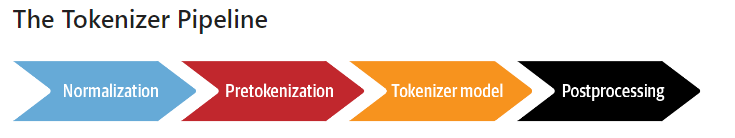


1. Normalization: Stripping whitespace, removing accents etc

2. Pretokenization: Splitting sentences into words.

3. Tokenizer Model: Actual model which does subword tokenozation.

4. Postprocessing: Add special tokens like [CLS] and [SEP]

# Sentence Piece vs Word Piece:

1. Uses unicode characters to perform encoding, so it makes the tokenizer language agnostic.

2. Whitespace assigned special Unicode character : U+2581 or the _ character 

In [54]:
"".join(xlmr_tokens)  ## Observe white space has _ character instead of whitespace

'<s>▁Jack▁Sparrow▁loves▁New▁Delhi</s>'

In [55]:
"".join(xlmr_tokens).replace(u"\u2581"," ")

'<s> Jack Sparrow loves New Delhi</s>'

# How NER works

Unlike Text classification, where we use the special [CLS] token to perform classification, in NER we use all the tokens and perform classification on each token according to IOB2 strategy. For subwords, ex: Rachinder, if this gets broken to "Rachin" and "##der" , only one of these can be classifier as B-PER. So which one should be selected?? IN BERT paper, the first token was used.


# Anatomy of Transformers

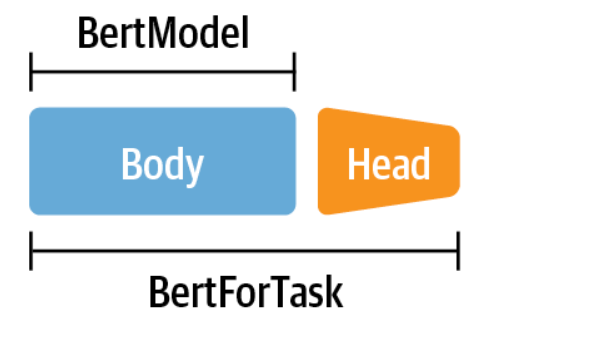

Body is task agnostic whereas head is task specific

# Custom Model for Token Classification

In [56]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [57]:
# The bare RoBERTa Model transformer outputting raw hidden-states without any specific head on top.
RobertaModel?

In [58]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
  config_class = XLMRobertaConfig

  def __init__(self, config):
    super().__init__(config)  ## For custom configuration, can overwrite this
    self.num_labels = config.num_labels
    self.roberta = RobertaModel(config, add_pooling_layer=False) ### return all hidden states, 
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    self.init_weights()

  def forward(self, input_ids = None, attention_mask = None, token_type_ids = None, labels = None, **kwargs):
    outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
    # Apply classifier to encoder representation
    sequence_output = self.dropout(outputs[0])
    logits = self.classifier(sequence_output)
    # Calculate losses
    loss = None
    if labels is not None:
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    # Return model output object
    return TokenClassifierOutput(loss=loss, logits=logits, 
                                  hidden_states=outputs.hidden_states, 
                                  attentions=outputs.attentions)  ### Token classifier output: specially for ner, Allows elements to be accessed as named tuple

In [59]:
TokenClassifierOutput?

# Loading custom model

In [60]:
tags

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], names_file=None, id=None)

In [61]:
tags.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [62]:
index2tag = {idx:tag for idx,tag in enumerate(tags.names)} # will be passed while loading the model

In [63]:
tag2index = {tag:idx for idx,tag in enumerate(tags.names)} # will be passed while loading the model

In [64]:
tag2index

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6}

In [65]:
index2tag

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC'}

In [66]:
from transformers import AutoConfig

In [67]:
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, num_labels = tags.num_classes, id2label = index2tag, label2id = tag2index)

In [68]:
xlmr_config

XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 5,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

# Loading weights

In [69]:
import torch

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [71]:
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))


# Quick Check  ----- Inference on new data points

In [72]:
xlmr_tokenizer.encode(text, return_tensors="pt")

tensor([[    0, 21763, 37456, 15555,  5161,     7,  2356, 55892,     2]])

In [73]:
xlmr_tokenizer.encode(text)

[0, 21763, 37456, 15555, 5161, 7, 2356, 55892, 2]

In [74]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")

In [75]:
pd.DataFrame([xlmr_tokens, input_ids.numpy()[0]], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁Delhi,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,55892,2


In [76]:
#### Predictions from the model

In [77]:
input_ids

tensor([[    0, 21763, 37456, 15555,  5161,     7,  2356, 55892,     2]])

In [78]:
xlmr_model?

In [79]:
xlmr_model(input_ids.to(device))

TokenClassifierOutput(loss=None, logits=tensor([[[-0.2171,  0.1914, -0.0741, -0.4676,  0.1013,  0.5010, -0.3431],
         [-0.3869,  0.5288,  0.1054, -0.3319, -0.1621,  0.2599, -0.3340],
         [-0.3139,  0.5189,  0.1425, -0.3502, -0.0755,  0.2925, -0.3506],
         [-0.3127,  0.6045,  0.1699, -0.3524, -0.2174,  0.1699, -0.3498],
         [-0.3366,  0.4821,  0.1008, -0.3481, -0.1980,  0.2895, -0.2167],
         [-0.3678,  0.4225,  0.0679, -0.3727, -0.1394,  0.2440, -0.3486],
         [-0.3945,  0.4939,  0.1483, -0.4676, -0.1559,  0.0935, -0.2383],
         [-0.3212,  0.5625,  0.2831, -0.2581, -0.2676,  0.1431, -0.2222],
         [-0.2501,  0.2057, -0.0298, -0.4775,  0.0936,  0.4892, -0.3033]]],
       grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)

In [80]:

outputs = xlmr_model(input_ids.to(device)).logits

In [81]:
predictions = torch.argmax(outputs, dim=-1)

In [82]:
outputs.shape

torch.Size([1, 9, 7])

In [83]:
[tags.names[p] for p in predictions[0]]

['B-LOC',
 'B-PER',
 'B-PER',
 'B-PER',
 'B-PER',
 'B-PER',
 'B-PER',
 'B-PER',
 'B-LOC']

In [84]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁Delhi,</s>
Tags,B-LOC,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-LOC


In [85]:
#### Inference function

def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

# Tokenize Texts for NER

In [86]:
de_example

{'tokens': ['2.000',
  'Einwohnern',
  'an',
  'der',
  'Danziger',
  'Bucht',
  'in',
  'der',
  'polnischen',
  'Woiwodschaft',
  'Pommern',
  '.'],
 'ner_tags': [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0],
 'langs': ['de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de'],
 'ner_tags_str': ['O',
  'O',
  'O',
  'O',
  'B-LOC',
  'I-LOC',
  'O',
  'O',
  'B-LOC',
  'B-LOC',
  'I-LOC',
  'O']}

In [87]:
words, labels = de_example["tokens"], de_example["ner_tags"]


In [88]:
de_example["tokens"]

['2.000',
 'Einwohnern',
 'an',
 'der',
 'Danziger',
 'Bucht',
 'in',
 'der',
 'polnischen',
 'Woiwodschaft',
 'Pommern',
 '.']

In [89]:

tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True) # is_split_into_words reflects words have already been  split into words

In [90]:
tokenized_input

{'input_ids': [0, 70101, 176581, 19, 142, 122, 2290, 708, 1505, 18363, 18, 23, 122, 127474, 15439, 13787, 14, 15263, 18917, 663, 6947, 19, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [91]:
xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

['<s>',
 '▁2.000',
 '▁Einwohner',
 'n',
 '▁an',
 '▁der',
 '▁Dan',
 'zi',
 'ger',
 '▁Buch',
 't',
 '▁in',
 '▁der',
 '▁polni',
 'schen',
 '▁Wo',
 'i',
 'wod',
 'schaft',
 '▁Po',
 'mmer',
 'n',
 '▁',
 '.',
 '</s>']

In [92]:
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [93]:
word_ids = tokenized_input.word_ids()

In [94]:
### need to ensure that if a word gets split into subwords, the second subword should not be considered
#### So, we set the token to -100, this is because pytorch cross entropy loss ignores -100 

In [95]:
previous_word_idx = None
label_ids = []

In [96]:
for word_idx in word_ids:
  if word_idx is None or word_idx == previous_word_idx:
    label_ids.append(-100)

  elif word_idx != previous_word_idx:
    label_ids.append(labels[word_idx])
  previous_word_idx = word_idx

In [97]:
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [98]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [99]:
def encode_panx_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched = True, remove_columns = ['langs', 'ner_tags','tokens'])

In [100]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

In [101]:
panx_de_encoded

DatasetDict({
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 6290
    })
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 12580
    })
})

# Performance metrics

In [102]:
#### seq val is a great library to generate scores for sequence evaluations

In [103]:
from seqeval.metrics import classification_report

In [104]:
y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]

In [105]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [106]:
## seqeval expects the inputs to be list of lists

In [107]:
import numpy as np

In [108]:
def allign_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis = 2)
  batch_size, seq_len = preds.shape
  labels_list , preds_list = [],[]

  for batch_idx in range(batch_size):
    example_labels, example_preds = [],[]

    for seq_idx in range(seq_len):
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])

      labels_list.append(example_labels)
      preds_list.append(example_preds)

  return preds_list, labels_list    



# Fine Tuning XLM-Roberta

In [109]:
from transformers import TrainingArguments

In [110]:
num_epochs = 1
batch_size = 24
logging_steps = len(panx_de_encoded["train"])// batch_size

In [111]:
model_name = f"{xlmr_model_name}-finetuned-panx-de"

In [112]:
training_args = TrainingArguments(
    output_dir = model_name, log_level = "error", num_train_epochs = num_epochs,
    per_device_train_batch_size=batch_size, per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch", save_steps=1e6, weight_decay=0.01, disable_tqdm = False,
    logging_steps = logging_steps)


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [113]:
from seqeval.metrics import f1_score

In [121]:
def compute_metrics(eval_predictions):
  y_pred, y_true = allign_predictions(eval_predictions.predictions, eval_predictions.label_ids)
  return {"f1":f1_score(y_true, y_pred)}

In [115]:
from transformers import DataCollatorForTokenClassification ## pad the sequences

In [116]:
## padding the sequeences
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [117]:
def model_init():
  return (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config = xlmr_config).to(device))

In [118]:
from transformers import Trainer

In [119]:
trainer = Trainer(model_init = model_init, args = training_args,
                  data_collator = data_collator, compute_metrics = compute_metrics, train_dataset = panx_de_encoded["train"],
                  eval_dataset = panx_de_encoded["validation"], tokenizer = xlmr_tokenizer)

In [120]:
# trainer.train()

Epoch,Training Loss,Validation Loss


NameError: ignored

In [137]:

# hide_output
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


In [141]:
from transformers import pipeline

In [ ]:
transformers_book_model = pipeline("token-classification",model = "transformersbook/xlm-roberta-base-finetuned-panx-de")

Downloading:   0%|          | 0.00/993 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

# Custom Project fiddling

Name
College Name
Degree
Graduation Year
Years of Experience
Companies worked at
Designation
Skills
Location
Email Address

In [122]:
from datasets import load_dataset

In [123]:

custom_data_path = "/content/Entity Recognition in Resumes.json"

In [124]:

custom_data = load_dataset("json", data_files = custom_data_path)

  0%|          | 0/1 [00:00<?, ?it/s]

In [125]:
custom_data

DatasetDict({
    train: Dataset({
        features: ['content', 'annotation', 'extras'],
        num_rows: 220
    })
})

In [126]:
data_point = custom_data["train"][5]

In [127]:
data_point.keys()

dict_keys(['content', 'annotation', 'extras'])

In [128]:
data_point

{'content': "Anvitha Rao\nAutomation developer\n\n- Email me on Indeed: indeed.com/r/Anvitha-Rao/9d6acc68cc30c71c\n\nSeeking a software development internship position for Summer 2018 that utilizes my technical\nskills, education and passion for\nsolving interesting problems as a software professional.\n\nWilling to relocate: Anywhere\n\nWORK EXPERIENCE\n\nAutomation developer\n\nSAP Labs -  Bengaluru, Karnataka -\n\nAugust 2016 to August 2017\n\nWorked as an automation developer in the development of cloud based Human capital\nmanagement System and\nIntegration frameworks Dell Boomi and SAP HANA Cloud Platform Integration.\n● Development of automation framework using Java Selenium and RestFul API's for payroll\nprojects.\n● Collaborating with customers on migrating Payroll projects to SAP HANA Cloud Platform\nIntegration.\n● Involved in regression, unity, functionality, performance, sanity and acceptance test driven\ndevelopment process.\n\nIntern\n\nSAP Labs -  Bengaluru, Karnataka -

In [129]:
custom_inputs = data_point["content"]

In [130]:
t_input = xlmr_tokenizer(custom_inputs)

In [131]:
xlmr_tokenizer.convert_ids_to_tokens(t_input['input_ids'])

['<s>',
 '▁An',
 'vit',
 'ha',
 '▁Rao',
 '▁Automat',
 'ion',
 '▁developer',
 '▁-',
 '▁Email',
 '▁me',
 '▁on',
 '▁Inde',
 'ed',
 ':',
 '▁indeed',
 '.',
 'com',
 '/',
 'r',
 '/',
 'An',
 'vit',
 'ha',
 '-',
 'Ra',
 'o',
 '/9',
 'd',
 '6',
 'a',
 'cc',
 '68',
 'cc',
 '30',
 'c',
 '71',
 'c',
 '▁See',
 'king',
 '▁a',
 '▁software',
 '▁development',
 '▁intern',
 'ship',
 '▁position',
 '▁for',
 '▁Summer',
 '▁2018',
 '▁that',
 '▁utilize',
 's',
 '▁my',
 '▁technical',
 '▁skills',
 ',',
 '▁education',
 '▁and',
 '▁passion',
 '▁for',
 '▁sol',
 'ving',
 '▁interesting',
 '▁problems',
 '▁as',
 '▁a',
 '▁software',
 '▁professional',
 '.',
 '▁Will',
 'ing',
 '▁to',
 '▁re',
 'locat',
 'e',
 ':',
 '▁Any',
 'where',
 '▁WORK',
 '▁EXP',
 'ERI',
 'ENCE',
 '▁Automat',
 'ion',
 '▁developer',
 '▁SAP',
 '▁Lab',
 's',
 '▁-',
 '▁Bengal',
 'uru',
 ',',
 '▁Karnataka',
 '▁-',
 '▁August',
 '▁2016',
 '▁to',
 '▁August',
 '▁2017',
 '▁Work',
 'ed',
 '▁as',
 '▁an',
 '▁automat',
 'ion',
 '▁developer',
 '▁in',
 '▁the',
 '▁dev

In [132]:
list(zip(t_input.word_ids(), xlmr_tokenizer.convert_ids_to_tokens(t_input['input_ids'])))

[(None, '<s>'),
 (0, '▁An'),
 (0, 'vit'),
 (0, 'ha'),
 (1, '▁Rao'),
 (2, '▁Automat'),
 (2, 'ion'),
 (3, '▁developer'),
 (4, '▁-'),
 (5, '▁Email'),
 (6, '▁me'),
 (7, '▁on'),
 (8, '▁Inde'),
 (8, 'ed'),
 (8, ':'),
 (9, '▁indeed'),
 (9, '.'),
 (9, 'com'),
 (9, '/'),
 (9, 'r'),
 (9, '/'),
 (9, 'An'),
 (9, 'vit'),
 (9, 'ha'),
 (9, '-'),
 (9, 'Ra'),
 (9, 'o'),
 (9, '/9'),
 (9, 'd'),
 (9, '6'),
 (9, 'a'),
 (9, 'cc'),
 (9, '68'),
 (9, 'cc'),
 (9, '30'),
 (9, 'c'),
 (9, '71'),
 (9, 'c'),
 (10, '▁See'),
 (10, 'king'),
 (11, '▁a'),
 (12, '▁software'),
 (13, '▁development'),
 (14, '▁intern'),
 (14, 'ship'),
 (15, '▁position'),
 (16, '▁for'),
 (17, '▁Summer'),
 (18, '▁2018'),
 (19, '▁that'),
 (20, '▁utilize'),
 (20, 's'),
 (21, '▁my'),
 (22, '▁technical'),
 (23, '▁skills'),
 (23, ','),
 (24, '▁education'),
 (25, '▁and'),
 (26, '▁passion'),
 (27, '▁for'),
 (28, '▁sol'),
 (28, 'ving'),
 (29, '▁interesting'),
 (30, '▁problems'),
 (31, '▁as'),
 (32, '▁a'),
 (33, '▁software'),
 (34, '▁professional'),
 (3

In [133]:
# split_words = custom_inputs.replace("\n"," ").split(" ")
split_words = custom_inputs.split(" ")

In [134]:
split_words

['Anvitha',
 'Rao\nAutomation',
 'developer\n\n-',
 'Email',
 'me',
 'on',
 'Indeed:',
 'indeed.com/r/Anvitha-Rao/9d6acc68cc30c71c\n\nSeeking',
 'a',
 'software',
 'development',
 'internship',
 'position',
 'for',
 'Summer',
 '2018',
 'that',
 'utilizes',
 'my',
 'technical\nskills,',
 'education',
 'and',
 'passion',
 'for\nsolving',
 'interesting',
 'problems',
 'as',
 'a',
 'software',
 'professional.\n\nWilling',
 'to',
 'relocate:',
 'Anywhere\n\nWORK',
 'EXPERIENCE\n\nAutomation',
 'developer\n\nSAP',
 'Labs',
 '-',
 '',
 'Bengaluru,',
 'Karnataka',
 '-\n\nAugust',
 '2016',
 'to',
 'August',
 '2017\n\nWorked',
 'as',
 'an',
 'automation',
 'developer',
 'in',
 'the',
 'development',
 'of',
 'cloud',
 'based',
 'Human',
 'capital\nmanagement',
 'System',
 'and\nIntegration',
 'frameworks',
 'Dell',
 'Boomi',
 'and',
 'SAP',
 'HANA',
 'Cloud',
 'Platform',
 'Integration.\n●',
 'Development',
 'of',
 'automation',
 'framework',
 'using',
 'Java',
 'Selenium',
 'and',
 'RestFul',
 "

In [135]:
custom_inputs[0:10+1]

'Anvitha Rao'

In [136]:
data_point["annotation"]

[{'label': ['Skills'],
  'points': [{'start': 2826,
    'end': 2878,
    'text': 'IoT, MySQL, PostgreSQL, D3js, Hadoop and Spark, Gephi'}]},
 {'label': ['Skills'],
  'points': [{'start': 2768,
    'end': 2809,
    'text': 'C, C++, HTML/CSS, Java, Python, Javascript'}]},
 {'label': ['Graduation Year'],
  'points': [{'start': 2513, 'end': 2516, 'text': '2016'}]},
 {'label': ['Location'],
  'points': [{'start': 2468, 'end': 2476, 'text': 'Bengaluru'}]},
 {'label': ['College Name'],
  'points': [{'start': 2429,
    'end': 2463,
    'text': 'M S Ramaiah Institute of Technology'}]},
 {'label': ['Degree'],
  'points': [{'start': 2384,
    'end': 2427,
    'text': 'Bachelor of Engineering in Computer Science\n'}]},
 {'label': ['Graduation Year'],
  'points': [{'start': 2378, 'end': 2381, 'text': '2019'}]},
 {'label': ['College Name'],
  'points': [{'start': 2329,
    'end': 2352,
    'text': 'Arizona State University'}]},
 {'label': ['Degree'],
  'points': [{'start': 2300,
    'end': 2327,
   

In [ ]:
test_path = "/content/test.txt"

In [ ]:
ds = load_dataset("text", data_files = test_path)

In [ ]:
ds

In [ ]:
ds["train"][5]

In [ ]:
custom_data.set_format?

In [ ]:
custom_data.set_format("pandas")

In [ ]:
df = custom_data["train"][:]

In [ ]:
df.head()

In [ ]:
### removing new line characters

df["content"] = df["content"].str.replace("\n", " ")

In [ ]:
df.head()